# Laboratorium 4

### Konfiguracja

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

FIG_EPS = 0.5

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < FIG_EPS:
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [12]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


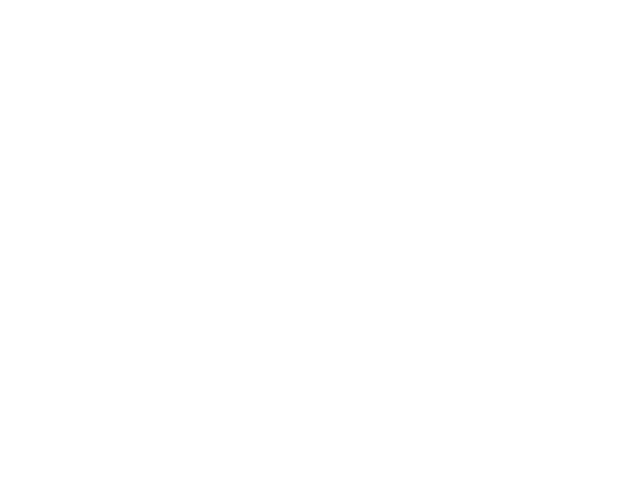

In [13]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


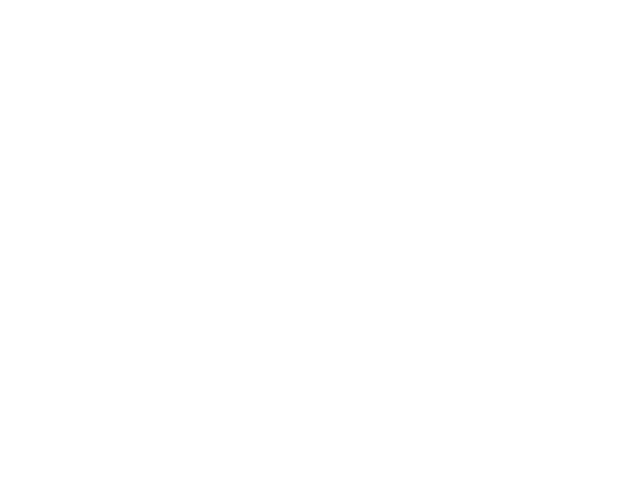

In [14]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


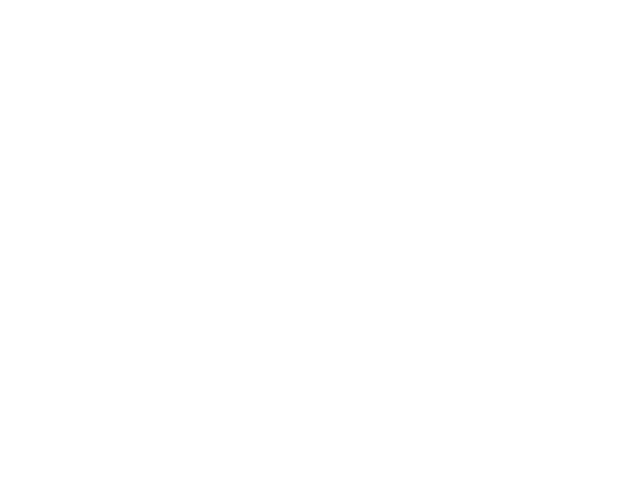

In [15]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


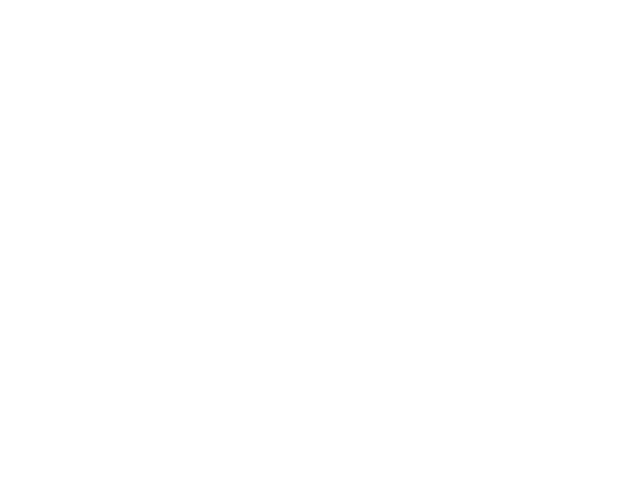

In [16]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

In [17]:
%matplotlib notebook

In [18]:
from enum import Enum

class VertexType(Enum):
    undefinedVertex = 0
    initialVertex = 1
    endVertex = 2
    bondingVertex = 3
    separatingVertex = 4
    correctVertex = 5
    
    def __lt__(self, other):
        return self.value < other.value

class Point:
    def __init__(self, x, y, vertexType = VertexType.undefinedVertex):
        self.x = x
        self.y = y
        self.left_point = None
        self.right_point = None
        self.vertexType = vertexType
        self.isLeftString = False
    
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
        
    def __str__(self):
        return "("+str(self.x)+", "+str(self.y)+")"
    


In [19]:
def rawToPointsArray(raw_points):
    points = []
    for point in raw_points:
        object_point = Point(point[0], point[1])
        points.append(object_point)
        
    for i in range(len(points)):
        if i == 0:
            points[i].left_point  = points[len(points)-1]
            points[i].right_point = points[1]
            continue
        elif i == (len(points)-1):
            points[i].left_point  = points[i-1]
            points[i].right_point = points[0]
            continue
            
        points[i].left_point  = points[i-1]
        points[i].right_point = points[i+1]
        
    return points

def pointsArrayToLinesCollection(points):
    lines = []
    for p in points:
        lines.append([(p.x, p.y),(p.right_point.x, p.right_point.y)])
        
    return lines

In [20]:
raw_points = plot1.get_added_elements().points[0].points

points = rawToPointsArray(raw_points)

#for p in points:
#    print(p, p.left_point, p.right_point)
    
lin = pointsArrayToLinesCollection(points)

<IPython.core.display.Javascript object>


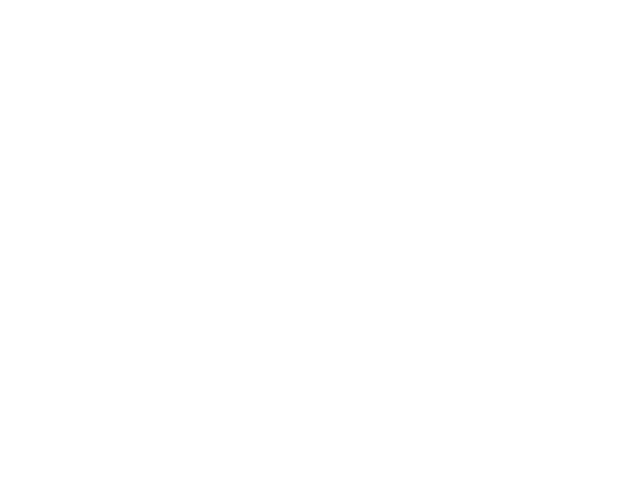

In [21]:
scenes=[Scene([PointsCollection(raw_points, color='green', marker = "^")], 
              [LinesCollection(lin)])]
plot = Plot(scenes)
plot.draw()

In [23]:
def isYMonotone(points):
    sortedPoints=sorted(points, key=lambda x: x.y, reverse=True)
    
    p = sortedPoints[0]
    while sortedPoints[len(sortedPoints)-1] != p:
        if p.left_point.y > p.y:
            return False
        p = p.left_point
        
    p = sortedPoints[0]
    while sortedPoints[len(sortedPoints)-1] != p:
        if p.right_point.y > p.y:
            return False
        p = p.right_point    
        
    return True

In [24]:
isYMonotone(points)

True

In [25]:
def det(a,b,c):
    return a.x*b.y + a.y*c.x + b.x*c.y - b.y*c.x - a.y*b.x - a.x*c.y

def classifyVertices(points):
    for p in points:
        if p.y > p.left_point.y and p.y > p.right_point.y and det(p.left_point, p, p.right_point) < 0:
            p.vertexType = VertexType.initialVertex
        elif p.y < p.left_point.y and p.y < p.right_point.y and det(p.left_point, p, p.right_point) < 0:
            p.vertexType = VertexType.endVertex
        elif p.y < p.left_point.y and p.y < p.right_point.y and det(p.left_point, p, p.right_point) > 0:
            p.vertexType = VertexType.bondingVertex
        elif p.y > p.left_point.y and p.y > p.right_point.y and det(p.left_point, p, p.right_point) > 0:
            p.vertexType = VertexType.separatingVertex
        else:
            p.vertexType = VertexType.correctVertex
            
def pointsToPointsCollections(points):
    initialVertex = []
    endVertex = []
    bondingVertex = []
    separatingVertex = []
    correctVertex = []
    
    for p in points:
        if p.vertexType == VertexType.initialVertex:
            initialVertex.append((p.x, p.y))
        elif p.vertexType == VertexType.endVertex:
            endVertex.append((p.x, p.y))
        elif p.vertexType == VertexType.bondingVertex:
            bondingVertex.append((p.x, p.y))
        elif p.vertexType == VertexType.separatingVertex:
            separatingVertex.append((p.x, p.y))
        elif p.vertexType == VertexType.correctVertex:
            correctVertex.append((p.x, p.y))
    
    return [PointsCollection(initialVertex, color='green', marker = "^"),
            PointsCollection(endVertex, color='red', marker = "^"),
            PointsCollection(bondingVertex, color='blue', marker = "^"),
            PointsCollection(separatingVertex, color='orange', marker = "^"),
            PointsCollection(correctVertex, color='brown', marker = "^")]

def pointsToPointsCollection(points):
    vertices = []
    for p in points:
        vertices.append((p.x, p.y))
    return [PointsCollection(vertices, color='green', marker = "^")]

In [26]:
classifyVertices(points)

<IPython.core.display.Javascript object>


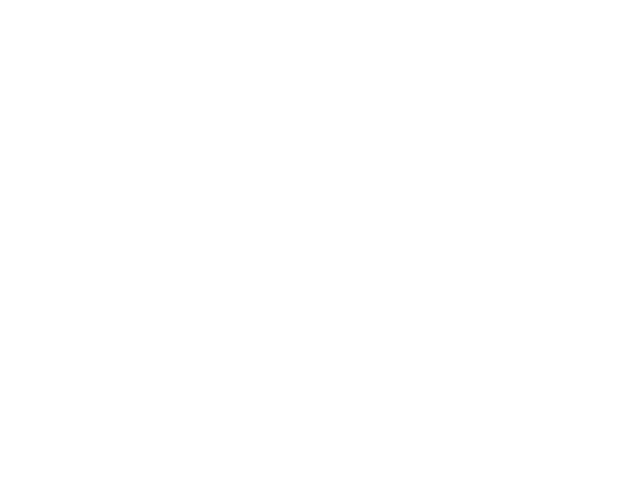

In [27]:
scenes=[Scene( pointsToPointsCollections(points), 
              [LinesCollection(lin)])]
plot = Plot(scenes)
plot.draw()

In [29]:
def addToScene(scenes, points, newLines, raw_lines, current_points):
    resLin = pointsArrayToLinesCollection(newLines)
    resLin.extend(raw_lines)
    scenes.append(Scene( 
        [pointsToPointsCollection(points)[0], PointsCollection(current_points, color='red', marker = "^")], 
        [LinesCollection(resLin)]))

def monotoneTriangulation(points):
    sortedPoints=sorted(points, key=lambda x: x.y, reverse=True)
    
    p = sortedPoints[0]
    while sortedPoints[len(sortedPoints)-1] != p:
        p.isLeftString = True
        p = p.left_point
        
    raw_lines = pointsArrayToLinesCollection(points)
    scenes = [Scene( pointsToPointsCollection(points), 
              [LinesCollection(raw_lines)])]    
    newLines = []
    stack = [sortedPoints[0], sortedPoints[1]]
    
    for v in sortedPoints[2:]:
        top = stack.pop()
        addToScene(scenes, points, newLines, raw_lines, [(v.x, v.y), (top.x, top.y)])
        if v.isLeftString == top.isLeftString:
            while True:
                if not stack:
                    stack.append(top)
                    stack.append(v)
                    break
                    
                second = stack.pop()
                addToScene(scenes, points, newLines, raw_lines, [(v.x, v.y), (second.x, second.y)])
                if v.isLeftString and det(v, top, second) > 1e-6:
                    stack.append(second)
                    stack.append(top)
                    stack.append(v)
                    break
                elif not v.isLeftString  and det(v, top, second) < -1e-6:
                    stack.append(second)
                    stack.append(top)
                    stack.append(v)
                    break
                else:
                    line = Point(v.x, v.y)
                    line.right_point = second
                    newLines.append(line)
                    addToScene(scenes, points, newLines, raw_lines, [(v.x, v.y), (second.x, second.y)])
                    stack.append(second)
                
                top = stack.pop()
                    
        else:
            line = Point(v.x, v.y)
            line.right_point = top
            newLines.append(line)
            addToScene(scenes, points, newLines, raw_lines, [(v.x, v.y), (top.x, top.y)])
             
            while stack:
                next_vertex = stack.pop()
                addToScene(scenes, points, newLines, raw_lines, [(v.x, v.y), (next_vertex.x, next_vertex.y)])
                
                if not next_vertex.left_point == v and not next_vertex.right_point == v:
                    new_line = Point(v.x, v.y)
                    new_line.right_point = next_vertex
                    newLines.append(new_line)
                    addToScene(scenes, points, newLines, raw_lines, [(v.x, v.y), (next_vertex.x, next_vertex.y)])
                    
            stack.append(top)
            stack.append(v)
            
    return newLines, scenes
        

In [30]:
res, scenes2 = monotoneTriangulation(points)

<IPython.core.display.Javascript object>


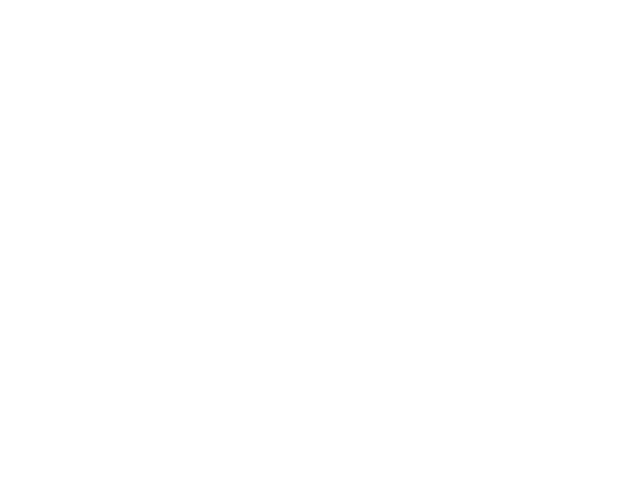

In [31]:
resLin = pointsArrayToLinesCollection(res)
resLin.extend(lin)
plot = Plot(scenes2)
plot.draw()